In [1]:
import os
import numpy as np
from glob import glob
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    # If you are using GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [3]:
# Hyperparameters
IMG_HEIGHT = 160
IMG_WIDTH = 240
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 7
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
set_seed(42)

In [4]:
TRAIN_IMG_DIR = '/kaggle/input/vehicles-semantic-segmentation/data/train/images'
TRAIN_MASK_DIR = '/kaggle/input/vehicles-semantic-segmentation/data/train/masks'

VAL_IMG_DIR = '/kaggle/input/vehicles-semantic-segmentation/data/val/images'
VAL_MASK_DIR = '/kaggle/input/vehicles-semantic-segmentation/data/val/masks'

In [5]:
class MyDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, random_state=None):
        super().__init__()
        if random_state:
            set_seed(random_state)
            
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace('.jpg', '_mask.gif'))

        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']

        return image, mask

In [6]:
train_transforms = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    A.Rotate(limit=35, p=0.5),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2(),
])

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=(64, 128, 256, 512), random_state=None):
        super(UNet, self).__init__()
        
        if random_state:
            set_seed(random_state)

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of Unet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of Unet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        # Bottleneck layer
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Final conv to change the number of channels (do not change HxW)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for index in range(0, len(self.ups), 2):
            x = self.ups[index](x)
            skip_connection = skip_connections[index // 2]

            if x.shape != skip_connection.shape:
                x = F.resize(x, size=skip_connection.shape[2:], antialias=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[index + 1](concat_skip)

        x = self.final_conv(x)

        return x

In [8]:
def calculate_metrics(labels, preds):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    
    for label, pred in zip(labels, preds):
        num_correct += (pred == label).sum()
        num_pixels += torch.numel(pred)
        
        dice_score += (2 * (pred * label).sum()) / ((pred + label).sum() + 1e-8)
        
    acc = num_correct / num_pixels
    dice_score /= len(preds)
    
    return acc, dice_score

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    
    total_loss = 0.0
    all_preds = []
    all_masks = []

    loop = tqdm(dataloader)
    for index, (imgs, masks) in enumerate(loop):
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        masks = masks.float().unsqueeze(1)  # adding the channel dimension

        optimizer.zero_grad()

        out = model(imgs)
        loss = loss_fn(out, masks)

        loss.backward()
        optimizer.step()
        
        total_loss += loss.cpu().item()
        
        preds = torch.sigmoid(out)
        preds = (preds > 0.5).float()
        all_preds.extend(preds.cpu())
        all_masks.extend(masks.cpu())
        
        loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(dataloader)
    acc, dice_score = calculate_metrics(all_masks, all_preds)
    return avg_loss, acc, dice_score

In [10]:
def evaluate(dataloader, model, loss_fn):
    model.eval()
    
    total_loss = 0.0
    all_preds = []
    all_masks = []
    with torch.no_grad():
        loop = tqdm(dataloader)
        for imgs, masks in loop:
            imgs = imgs.to(DEVICE)
            masks = masks.float().unsqueeze(1).to(DEVICE)

            out = model(imgs)
            loss = loss_fn(out, masks)
            total_loss += loss.cpu().item()
            
            preds = torch.sigmoid(out)
            preds = (preds > 0.5).float()
            all_preds.extend(preds.cpu())
            all_masks.extend(masks.cpu())
            
            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader)
    acc, dice_score = calculate_metrics(all_masks, all_preds)

    # print(f'Got correct {num_correct} out of all {num_pixels} pixels. Accuracy = {acc * 100:.2f}')
    # print(f'Dice score = {dice_score}')
    return avg_loss, acc, dice_score

In [11]:
train_dataset = MyDataset(TRAIN_IMG_DIR,
                          TRAIN_MASK_DIR,
                          transform=train_transforms,
                          random_state=42)
val_dataset = MyDataset(VAL_IMG_DIR,
                        VAL_MASK_DIR,
                        transform=val_transforms,
                        random_state=42)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
model = UNet(in_channels=3, out_channels=1, random_state=42).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

In [13]:
def run_training(train_loader, val_loader, model, loss_fn, optimizer, patience=PATIENCE, epochs=EPOCHS):
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    dice_scores = {'train': [], 'val': []}
    best_dice_score = 0.0
    
    for epoch in range(epochs):
        train_loss, train_acc, train_dice = train(train_loader, model, loss_fn, optimizer)
        losses['train'].append(train_loss)
        accuracies['train'].append(train_acc)
        dice_scores['train'].append(train_dice)

        val_loss, val_acc, val_dice = evaluate(val_loader, model, loss_fn)
        losses['val'].append(val_loss)
        accuracies['val'].append(val_acc)
        dice_scores['val'].append(val_dice)

        print(f'Epoch {epoch + 1}\n\tTrain Loss: {train_loss} | '
              f'Validation Loss: {val_loss}\n\tTrain Accuracy: {train_acc} | '
              f'Validation accuracy: {val_acc}\n\tTrain dice score: {train_dice} | '
              f'Validation dice score: {val_dice}')
        
        if val_dice > best_dice_score:
            best_dice_score = val_dice
            counter = 0
            print(f'\t...Saving Best Model at Epoch {epoch + 1}...')
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            counter += 1
            if counter > patience:
                print(f'Early Stopping at epoch {epoch + 1}...')
                break
    
    print('Training Complete!')
    return losses, accuracies, dice_scores

In [14]:
losses, accuracies, dice_scores = run_training(train_loader,
                                               val_loader,
                                               model=model,
                                               loss_fn=loss_fn,
                                               optimizer=optimizer)

100%|██████████| 32/32 [00:42<00:00,  1.34s/it, loss=0.181]


Epoch 1
	Train Loss: 0.2577784302411601 | Validation Loss: 0.18158018868416548
	Train Accuracy: 0.965778648853302 | Validation accuracy: 0.9896602630615234
	Train dice score: 0.9266464710235596 | Validation dice score: 0.975892186164856
	...Saving Best Model at Epoch 1...


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.138]


Epoch 2
	Train Loss: 0.1636796344537288 | Validation Loss: 0.13805013336241245
	Train Accuracy: 0.9890753626823425 | Validation accuracy: 0.992098867893219
	Train dice score: 0.9741272926330566 | Validation dice score: 0.9815242290496826
	...Saving Best Model at Epoch 2...


100%|██████████| 32/32 [00:36<00:00,  1.13s/it, loss=0.112]


Epoch 3
	Train Loss: 0.12704654346453026 | Validation Loss: 0.1125458765309304
	Train Accuracy: 0.9909771680831909 | Validation accuracy: 0.9910351037979126
	Train dice score: 0.9785746335983276 | Validation dice score: 0.9792307019233704


100%|██████████| 32/32 [00:34<00:00,  1.09s/it, loss=0.128]


Epoch 4
	Train Loss: 0.10285328677855432 | Validation Loss: 0.12774438317865133
	Train Accuracy: 0.991384744644165 | Validation accuracy: 0.9745835661888123
	Train dice score: 0.9796657562255859 | Validation dice score: 0.9412696957588196


100%|██████████| 32/32 [00:36<00:00,  1.14s/it, loss=0.0746]


Epoch 5
	Train Loss: 0.0841504767886363 | Validation Loss: 0.0784988054074347
	Train Accuracy: 0.9920423626899719 | Validation accuracy: 0.990994393825531
	Train dice score: 0.9811357259750366 | Validation dice score: 0.9795997738838196


100%|██████████| 32/32 [00:35<00:00,  1.10s/it, loss=0.0615]


Epoch 6
	Train Loss: 0.06961415315163322 | Validation Loss: 0.06170685775578022
	Train Accuracy: 0.9927585124969482 | Validation accuracy: 0.9946004152297974
	Train dice score: 0.9827769994735718 | Validation dice score: 0.9873651266098022
	...Saving Best Model at Epoch 6...


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.0527]


Epoch 7
	Train Loss: 0.05832099076360464 | Validation Loss: 0.0526899624383077
	Train Accuracy: 0.9934021234512329 | Validation accuracy: 0.9944477677345276
	Train dice score: 0.984279215335846 | Validation dice score: 0.9870709180831909


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.0439]


Epoch 8
	Train Loss: 0.05025835786364041 | Validation Loss: 0.04418435331899673
	Train Accuracy: 0.9935908913612366 | Validation accuracy: 0.9948588013648987
	Train dice score: 0.9847229719161987 | Validation dice score: 0.9880311489105225
	...Saving Best Model at Epoch 8...


100%|██████████| 32/32 [00:36<00:00,  1.15s/it, loss=0.0399]


Epoch 9
	Train Loss: 0.04348143783863634 | Validation Loss: 0.03967127401847392
	Train Accuracy: 0.9939863085746765 | Validation accuracy: 0.9947121739387512
	Train dice score: 0.9857186675071716 | Validation dice score: 0.9875041246414185


100%|██████████| 32/32 [00:37<00:00,  1.18s/it, loss=0.0362]


Epoch 10
	Train Loss: 0.03992873465176672 | Validation Loss: 0.036037967540323734
	Train Accuracy: 0.993546187877655 | Validation accuracy: 0.9949803352355957
	Train dice score: 0.9846501350402832 | Validation dice score: 0.9882273077964783
	...Saving Best Model at Epoch 10...


100%|██████████| 32/32 [00:36<00:00,  1.14s/it, loss=0.0306]


Epoch 11
	Train Loss: 0.03492891548376065 | Validation Loss: 0.030605222622398287
	Train Accuracy: 0.9940966367721558 | Validation accuracy: 0.9952046275138855
	Train dice score: 0.9859989285469055 | Validation dice score: 0.9887309074401855
	...Saving Best Model at Epoch 11...


100%|██████████| 32/32 [00:35<00:00,  1.11s/it, loss=0.0307]


Epoch 12
	Train Loss: 0.03511915857961867 | Validation Loss: 0.03112749068532139
	Train Accuracy: 0.9928642511367798 | Validation accuracy: 0.9944052696228027
	Train dice score: 0.9831229448318481 | Validation dice score: 0.9868600964546204


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.025]


Epoch 13
	Train Loss: 0.030504459180519916 | Validation Loss: 0.025285937765147537
	Train Accuracy: 0.9937075972557068 | Validation accuracy: 0.9953060746192932
	Train dice score: 0.9851037263870239 | Validation dice score: 0.9889790415763855
	...Saving Best Model at Epoch 13...


100%|██████████| 32/32 [00:35<00:00,  1.11s/it, loss=0.0225]


Epoch 14
	Train Loss: 0.026361482028733008 | Validation Loss: 0.02271928294794634
	Train Accuracy: 0.9945794343948364 | Validation accuracy: 0.995698869228363
	Train dice score: 0.9870971441268921 | Validation dice score: 0.9899476766586304
	...Saving Best Model at Epoch 14...


100%|██████████| 32/32 [00:35<00:00,  1.10s/it, loss=0.0219]


Epoch 15
	Train Loss: 0.02444336838379968 | Validation Loss: 0.02214111277135089
	Train Accuracy: 0.9946708679199219 | Validation accuracy: 0.9955499172210693
	Train dice score: 0.9872953295707703 | Validation dice score: 0.9896087050437927


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.0219]


Epoch 16
	Train Loss: 0.02399056710419245 | Validation Loss: 0.022171601362060755
	Train Accuracy: 0.9942785501480103 | Validation accuracy: 0.9950810670852661
	Train dice score: 0.9864460229873657 | Validation dice score: 0.9885491728782654


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.0198]


Epoch 17
	Train Loss: 0.023247825243743137 | Validation Loss: 0.020170511328615248
	Train Accuracy: 0.9941034913063049 | Validation accuracy: 0.9950780868530273
	Train dice score: 0.9860075116157532 | Validation dice score: 0.988379180431366


100%|██████████| 32/32 [00:34<00:00,  1.08s/it, loss=0.0172]


Epoch 18
	Train Loss: 0.020235143863828853 | Validation Loss: 0.017243406211491674
	Train Accuracy: 0.9949065446853638 | Validation accuracy: 0.9960107803344727
	Train dice score: 0.987870454788208 | Validation dice score: 0.9906190633773804
	...Saving Best Model at Epoch 18...


100%|██████████| 32/32 [00:35<00:00,  1.11s/it, loss=0.0162]


Epoch 19
	Train Loss: 0.01882452364952769 | Validation Loss: 0.016173455980606377
	Train Accuracy: 0.9951261281967163 | Validation accuracy: 0.9962109327316284
	Train dice score: 0.9883936047554016 | Validation dice score: 0.9911085367202759
	...Saving Best Model at Epoch 19...


100%|██████████| 32/32 [00:35<00:00,  1.10s/it, loss=0.015]


Epoch 20
	Train Loss: 0.017863899964140728 | Validation Loss: 0.01518355798907578
	Train Accuracy: 0.9952126145362854 | Validation accuracy: 0.99620521068573
	Train dice score: 0.988600492477417 | Validation dice score: 0.9911086559295654
	...Saving Best Model at Epoch 20...


100%|██████████| 32/32 [00:35<00:00,  1.11s/it, loss=0.0179]


Epoch 21
	Train Loss: 0.020201198596623726 | Validation Loss: 0.01831654564011842
	Train Accuracy: 0.9940747618675232 | Validation accuracy: 0.9951843619346619
	Train dice score: 0.9859052896499634 | Validation dice score: 0.9887064099311829


100%|██████████| 32/32 [00:35<00:00,  1.11s/it, loss=0.0401]


Epoch 22
	Train Loss: 0.019508401688653976 | Validation Loss: 0.04275444825179875
	Train Accuracy: 0.99406498670578 | Validation accuracy: 0.9868117570877075
	Train dice score: 0.9859015345573425 | Validation dice score: 0.9703564047813416


100%|██████████| 32/32 [00:35<00:00,  1.10s/it, loss=0.0142]


Epoch 23
	Train Loss: 0.018353329127421603 | Validation Loss: 0.014431023882934824
	Train Accuracy: 0.9942898154258728 | Validation accuracy: 0.9959948062896729
	Train dice score: 0.9863883256912231 | Validation dice score: 0.9905677437782288


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.0138]


Epoch 24
	Train Loss: 0.01615913773275679 | Validation Loss: 0.013671793072717264
	Train Accuracy: 0.9950003027915955 | Validation accuracy: 0.9960299134254456
	Train dice score: 0.9880625009536743 | Validation dice score: 0.9906802177429199


100%|██████████| 32/32 [00:35<00:00,  1.11s/it, loss=0.0125]


Epoch 25
	Train Loss: 0.01542134928604355 | Validation Loss: 0.012716285535134375
	Train Accuracy: 0.9951685070991516 | Validation accuracy: 0.9962555170059204
	Train dice score: 0.9884809851646423 | Validation dice score: 0.9912208914756775
	...Saving Best Model at Epoch 25...


100%|██████████| 32/32 [00:34<00:00,  1.09s/it, loss=0.0119]


Epoch 26
	Train Loss: 0.014576677647710312 | Validation Loss: 0.012153098970884457
	Train Accuracy: 0.9953651428222656 | Validation accuracy: 0.9962984919548035
	Train dice score: 0.9889484643936157 | Validation dice score: 0.9913121461868286
	...Saving Best Model at Epoch 26...


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.0124]


Epoch 27
	Train Loss: 0.01416080058697844 | Validation Loss: 0.01242609607288614
	Train Accuracy: 0.9954226016998291 | Validation accuracy: 0.9960675835609436
	Train dice score: 0.9890586137771606 | Validation dice score: 0.9907552599906921


100%|██████████| 32/32 [00:35<00:00,  1.11s/it, loss=0.0112]


Epoch 28
	Train Loss: 0.01375499292043969 | Validation Loss: 0.01151314508751966
	Train Accuracy: 0.9954773783683777 | Validation accuracy: 0.9964526295661926
	Train dice score: 0.9892137050628662 | Validation dice score: 0.9916736483573914
	...Saving Best Model at Epoch 28...


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.0108]


Epoch 29
	Train Loss: 0.013482913040206768 | Validation Loss: 0.011155632353620604
	Train Accuracy: 0.9954881072044373 | Validation accuracy: 0.9965400099754333
	Train dice score: 0.9892613291740417 | Validation dice score: 0.9918795824050903
	...Saving Best Model at Epoch 29...


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.0105]


Epoch 30
	Train Loss: 0.013018884179473389 | Validation Loss: 0.010718278557760641
	Train Accuracy: 0.995583713054657 | Validation accuracy: 0.9966241121292114
	Train dice score: 0.9894750714302063 | Validation dice score: 0.9920803308486938
	...Saving Best Model at Epoch 30...


100%|██████████| 32/32 [00:35<00:00,  1.11s/it, loss=0.0177]


Epoch 31
	Train Loss: 0.012816326197935268 | Validation Loss: 0.026310857094358653
	Train Accuracy: 0.995593249797821 | Validation accuracy: 0.992773711681366
	Train dice score: 0.989499568939209 | Validation dice score: 0.9822725057601929


100%|██████████| 32/32 [00:35<00:00,  1.11s/it, loss=0.339]


Epoch 32
	Train Loss: 0.023127566877519712 | Validation Loss: 0.33963057212531567
	Train Accuracy: 0.9919491410255432 | Validation accuracy: 0.866464376449585
	Train dice score: 0.9809176921844482 | Validation dice score: 0.768837034702301


100%|██████████| 32/32 [00:35<00:00,  1.11s/it, loss=0.0114]


Epoch 33
	Train Loss: 0.016470834707433823 | Validation Loss: 0.011746227857656777
	Train Accuracy: 0.9940544366836548 | Validation accuracy: 0.996059238910675
	Train dice score: 0.985878586769104 | Validation dice score: 0.9907767176628113


100%|██████████| 32/32 [00:37<00:00,  1.18s/it, loss=0.0109]


Epoch 34
	Train Loss: 0.013980778829136398 | Validation Loss: 0.01107649359619245
	Train Accuracy: 0.9949598908424377 | Validation accuracy: 0.9962140917778015
	Train dice score: 0.9879648089408875 | Validation dice score: 0.9910927414894104


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.0108]


Epoch 35
	Train Loss: 0.013304265492479317 | Validation Loss: 0.010816381749464199
	Train Accuracy: 0.9951850175857544 | Validation accuracy: 0.9962523579597473
	Train dice score: 0.9885420799255371 | Validation dice score: 0.9912168383598328


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.0112]


Epoch 36
	Train Loss: 0.012942537316121161 | Validation Loss: 0.01091417923453264
	Train Accuracy: 0.995317280292511 | Validation accuracy: 0.9960705041885376
	Train dice score: 0.9888699054718018 | Validation dice score: 0.99078768491745


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.00997]


Epoch 37
	Train Loss: 0.012337242900684942 | Validation Loss: 0.010029529599705711
	Train Accuracy: 0.9954847693443298 | Validation accuracy: 0.996505618095398
	Train dice score: 0.9892330169677734 | Validation dice score: 0.9918290972709656


100%|██████████| 32/32 [00:35<00:00,  1.12s/it, loss=0.00947]

Epoch 38
	Train Loss: 0.011965191260969732 | Validation Loss: 0.009604532911907881
	Train Accuracy: 0.9955841302871704 | Validation accuracy: 0.996595025062561
	Train dice score: 0.9894557595252991 | Validation dice score: 0.9920397996902466
Early Stopping at epoch 38...
Training Complete!


In [15]:
n_epochs = len(losses['train'])

In [16]:
def plot_graphs(losses, accuracies, dice_scores):
    fig, ax = plt.subplots(3, 1, figsize=(12, 12))

    ax[0].plot(np.arange(n_epochs) + 1, losses['train'], label='Train', c='blue')
    ax[0].plot(np.arange(n_epochs) + 1, losses['val'], label='Validation', c='orange')
    ax[0].set_ylabel('Loss', fontsize=14)
    ax[0].legend()

    ax[1].plot(np.arange(n_epochs) + 1, accuracies['train'], label='Train', c='blue')
    ax[1].plot(np.arange(n_epochs) + 1, accuracies['val'], label='Validation', c='orange')
    ax[1].set_ylabel('Accuracy', fontsize=14)
    ax[1].legend()

    ax[2].plot(np.arange(n_epochs) + 1, dice_scores['train'], label='Train', c='blue')
    ax[2].plot(np.arange(n_epochs) + 1, dice_scores['val'], label='Validation', c='orange')
    ax[2].set_ylabel('Dice score', fontsize=14)
    ax[2].legend()

    plt.xlabel('Epochs')
    fig.suptitle('Training period', fontsize=16)
    plt.tight_layout()
    plt.show()

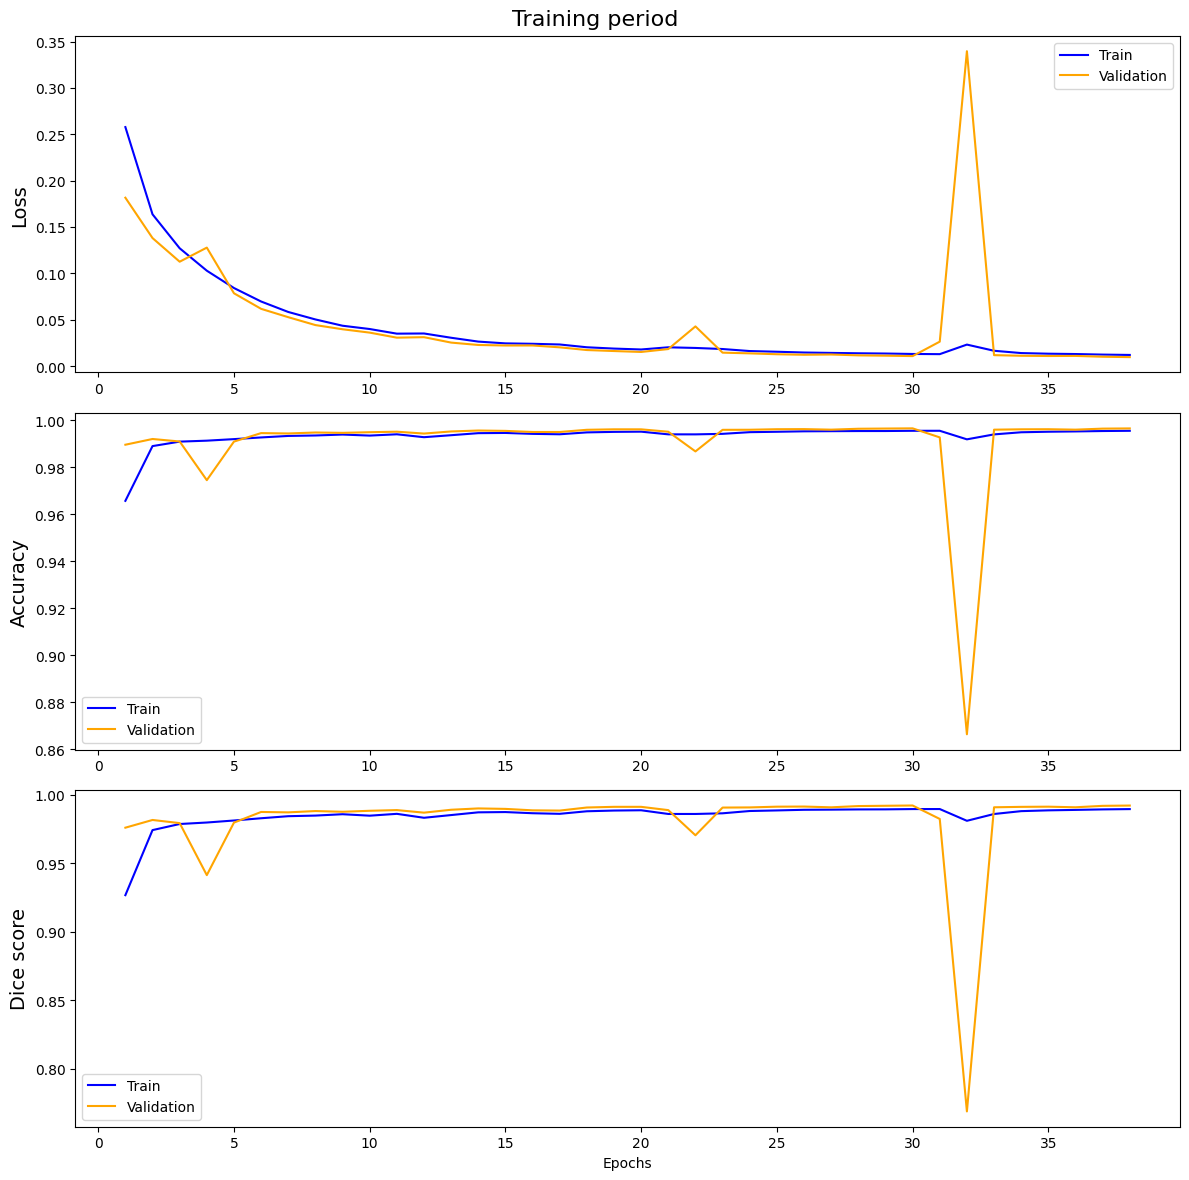

In [17]:
plot_graphs(losses, accuracies, dice_scores)